In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import model_selection as sk
import os, re, h5py, shutil
from urllib.request import urlretrieve
from urllib.error import HTTPError
import sklearn
from os import listdir

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [138]:
%matplotlib inline

In [2]:
folder = sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=42)

In [3]:
def file_checkup(drt):
    directory = drt #"/home/ubuntu/Downloads/FERG_DB_256/Images"
    files_dir =  listdir(directory)
    newlist = []
    for names in files_dir:
        try:
            if names.endswith(".png"):
                if tf.keras.preprocessing.image.load_img(drt+'/{}'.format(names)):
                    newlist.append(names)
        except OSError:
            continue
    d = {'names': newlist}
    df = pd.DataFrame(data = d)
    return df

In [4]:
#pwd

In [5]:
# df_anger = file_checkup('./FERG_DB_256/anger')

In [6]:
# df_disgust = file_checkup('./FERG_DB_256/disgust')
# df_fear = file_checkup('./FERG_DB_256/fear')
# df_joy = file_checkup('./FERG_DB_256/joy')
# df_neutral = file_checkup('./FERG_DB_256/neutral')
# df_sadness = file_checkup('./FERG_DB_256/sadness')
# df_surprise = file_checkup('./FERG_DB_256/surprise')

In [7]:
def make_folds(df):
    folds = []
    for fold_idx, split in enumerate(folder.split(X=df.index.values)):
        folds.append(split)
    return folds

In [8]:
# anger_folds = make_folds(df_anger)

In [9]:
# disgust_folds = make_folds(df_disgust)
# fear_folds = make_folds(df_fear)
# joy_folds = make_folds(df_joy)
# neutral_folds = make_folds(df_neutral)
# sadness_folds = make_folds(df_sadness)
# surprise_folds = make_folds(df_surprise)

In [10]:
train_path = r'./{}'.format('train')
if not os.path.exists(train_path):
    os.makedirs(train_path)

In [11]:
valid_path = r'./{}'.format('valid')
if not os.path.exists(valid_path):
    os.makedirs(valid_path)

In [12]:
# cl = 'anger'
# df = file_checkup('./FERG_DB_256/{}'.format(cl))
# tst_fold = make_folds(df)
# tst_fold[0][0]

In [13]:
# df_anger.head()

In [14]:
# tst_train_path = r'./train/{}'.format(cl)
# print (os.path.join(tst_train_path, df_anger['names'][0]))

In [15]:
# cl = 'test'
# tst_train_path = r'./train/{}'.format(cl)
# if not os.path.exists(tst_train_path+'/{}'.format(cl)):
#     os.makedirs(tst_train_path+'/{}'.format(cl))

In [16]:
def run_k_fold(k, cl):
    df = file_checkup('./FERG_DB_256/{}'.format(cl))
    fold = make_folds(df)[k]
    train_path = r'./train/{}'.format(cl)
    valid_path = r'./valid/{}'.format(cl)
    if not os.path.exists(train_path+'/{}'.format(cl)):
        os.makedirs(train_path+'/{}'.format(cl))
    if not os.path.exists(valid_path+'/{}'.format(cl)):
        os.makedirs(valid_path+'/{}'.format(cl))
    train_df = df.loc[fold[0]]
    valid_df = df.loc[fold[1]]
    for member in train_df['names'].values:
        os.link('./FERG_DB_256/{}/{}'.format(cl, member), os.path.join(train_path, member))
    for member in valid_df['names'].values:
        os.link('./FERG_DB_256/{}/{}'.format(cl, member), os.path.join(valid_path, member))

In [17]:
run_k_fold(0, 'disgust')
run_k_fold(0, 'fear')
run_k_fold(0, 'joy')
run_k_fold(0, 'neutral')
run_k_fold(0, 'sadness')
run_k_fold(0, 'surprise')

FileExistsError: [Errno 17] File exists: './FERG_DB_256/disgust/aia_disgust_1001.png' -> './train/disgust/aia_disgust_1001.png'

In [ ]:
run_k_fold(0, 'anger')

In [18]:
train_feed = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2,
    height_shift_range=0.2)
train_iter = train_feed.flow_from_directory(
    './train/', target_size=(48, 48), follow_links=True, class_mode='categorical', batch_size=32)
valid_feed = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, width_shift_range=0,
    height_shift_range=0)
valid_iter = valid_feed.flow_from_directory(
    './valid/', target_size=(48, 48), follow_links=True, class_mode='categorical', batch_size=32)

Found 37175 images belonging to 7 classes.
Found 18591 images belonging to 7 classes.


In [19]:
conv_arch=[(32,3),(64,3),(128,3)]
dense=[64,2]
dropout=0.5
patience=5

In [20]:
INPUT_SHAPE = (48, 48, 3)
OUTPUT_SHAPE = (7,)

In [21]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution2D(filters=conv_arch[0][0], kernel_size=(3, 3), 
                        padding='same', activation='relu', input_shape=INPUT_SHAPE))

if (conv_arch[0][1]-1) != 0:
    for i in range(conv_arch[0][1]-1):
        model.add(tf.keras.layers.Convolution2D(conv_arch[0][0], kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

if conv_arch[1][1] != 0:
    for i in range(conv_arch[1][1]):
        model.add(tf.keras.layers.Convolution2D(conv_arch[1][0], kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

if conv_arch[2][1] != 0:
    for i in range(conv_arch[2][1]):
        model.add(tf.keras.layers.Convolution2D(conv_arch[2][0], kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())  # this converts 3D feature maps to 1D feature vectors
if dense[1] != 0:
    for i in range(dense[1]):
        model.add(tf.keras.layers.Dense(dense[0], activation='relu'))
        if dropout:
            model.add(tf.keras.layers.Dropout(dropout))
prediction = model.add(tf.keras.layers.Dense(OUTPUT_SHAPE[0], activation='softmax'))

# optimizer:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# set callback:
callbacks = []
if patience != 0:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    callbacks.append(early_stopping)

print ('Training....')

Training....


In [ ]:
stop

In [22]:
'''without data augmentation'''
hist = model.fit_generator(train_iter, validation_data=valid_iter, 
                           steps_per_epoch=train_iter.samples//train_iter.batch_size,
                          validation_steps=5, callbacks=callbacks, 
                 use_multiprocessing=True, workers=1, epochs=10)

Epoch 1/10
1161/1161 [==============================] - 120s - loss: 1.9344 - acc: 0.1615 - val_loss: 1.8636 - val_acc: 0.1562
Epoch 2/10
1161/1161 [==============================] - 116s - loss: 1.5607 - acc: 0.3260 - val_loss: 0.9483 - val_acc: 0.5750
Epoch 3/10
1161/1161 [==============================] - 117s - loss: 0.7764 - acc: 0.6702 - val_loss: 0.1766 - val_acc: 0.9688
Epoch 4/10
1161/1161 [==============================] - 117s - loss: 0.3021 - acc: 0.9091 - val_loss: 0.0455 - val_acc: 0.9875
Epoch 5/10
1161/1161 [==============================] - 117s - loss: 0.1832 - acc: 0.9493 - val_loss: 0.0203 - val_acc: 0.9875
Epoch 6/10
1161/1161 [==============================] - 117s - loss: 0.1683 - acc: 0.9581 - val_loss: 0.0287 - val_acc: 0.9938
Epoch 7/10
1161/1161 [==============================] - 117s - loss: 0.1066 - acc: 0.9716 - val_loss: 7.8987e-05 - val_acc: 1.0000
Epoch 8/10
1161/1161 [==============================] - 117s - loss: 0.1180 - acc: 0.9709 - val_loss: 0.030

In [23]:
model.save('multiclass')

In [184]:
# def get_confusion(data_iter, model):
#     data_iter.reset()
#     y_predict = model.predict_generator(data_iter, steps=(data_iter.samples//data_iter.batch_size)+1,
#         use_multiprocessing=True, workers=1)
#     return y_predict, sklearn.metrics.confusion_matrix(data_iter.classes, 
#                                             np.argmax(y_predict.astype(int), axis=1))

In [194]:
def get_confusion2(data_iter, model):
    # Reset data iter so that it starts from batch 0
    data_iter.reset()
    samples = ((data_iter.samples//data_iter.batch_size))*32
    prog = tf.keras.utils.Progbar(target=samples)
    # Initialize empty arrays to store values
    y_true = np.empty(shape=(samples, OUTPUT_SHAPE[0]), dtype=np.float32)
    y_predict = np.empty(shape=(samples, OUTPUT_SHAPE[0]), dtype=np.float32)
    X = np.empty(shape=((data_iter.batch_size,) + INPUT_SHAPE[:]), dtype=np.float32)
    # For every batch,
    a, b = (0, 0,)
    for i in range((samples//data_iter.batch_size)-2):
        try:
            # Get X and y_true
            X[:], y_temp = data_iter.next()
            b += y_temp.shape[0]
            prog.update(b)
            y_true[a : b] = y_temp
            # predict X and y
            y_predict[a : b] = model.predict(X, verbose=0)
            a = b
        except ValueError:
            return y_predict, y_true, a, b
    return y_predict, y_true, a, b#, #sklearn.metrics.confusion_matrix(y_true, y_predict)

In [185]:
#y_predict, cnf_matrix = get_confusion(valid_iter, model)

In [195]:
y_predict, y_true, a, b = get_confusion2(valid_iter, model)

18496/18560 [============================>.] - ETA: 0s

In [192]:
#np.argmax(y_predict, axis=1)[0:5]

array([3, 1, 6, 6, 2])

In [193]:
#valid_iter.classes[0:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [196]:
cnf_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_true[:a], axis=1), np.argmax(y_predict[:a], axis=1))

In [197]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.99648011e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.51988736e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.11015208e-04 4.11015208e-04 9.93423757e-01
  5.75421291e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.61509173e-03 0.00000000e+00
  1.73070267e-03 0.00000000e+00 9.90654206e-01]]


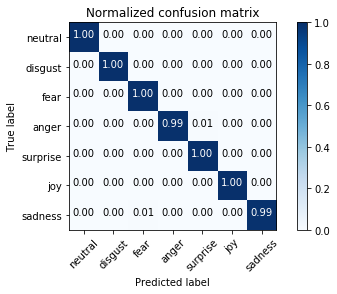

In [198]:
plt.figure()
import itertools
plot_confusion_matrix(cnf_matrix, classes=list(valid_iter.class_indices.keys()), normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [155]:
list(valid_iter.class_indices.keys())

['neutral', 'disgust', 'fear', 'anger', 'surprise', 'joy', 'sadness']

In [281]:
def get_bad_images(data_iter, y_predict, y_true):
    data_iter.reset()
    selector = (np.argmax(y_predict, axis=1) != np.argmax(y_true, axis=1))
    samples = ((data_iter.samples//data_iter.batch_size))*32
    prog = tf.keras.utils.Progbar(target=samples)
    images = np.empty(shape = (selector.sum(), 48, 48, 3))
    # For every batch,
    batch_ind, batch_ind_end = (0, 0,)
    image_ind, image_ind_end = (0, 0,)
    for i in range((samples//data_iter.batch_size)-2):
        try:
            # Get X and y_true
            X, y_temp = data_iter.next()
            batch_ind_end += y_temp.shape[0]
            temp = X[selector[batch_ind : batch_ind_end]]
            image_ind_end = temp.shape[0]
            images[image_ind : image_ind_end] = temp
            prog.update(b)
            # predict X and y
            batch_ind = batch_ind_end
            image_ind = image_ind_end
        except ValueError:
            return images, selector
    return images, selector#, #sklearn.metrics.confusion_matrix(y_true, y_predict)

In [282]:
images, selector = get_bad_images(valid_iter, y_predict, y_true)

18496/18560 [============================>.] - ETA: 0s

In [337]:
idx=0
bad_images = np.asarray(valid_iter.filenames[:selector.shape[0]])[selector]
name_lookup  = {valid_iter.class_indices[key]: key for key in valid_iter.class_indices.keys()}

In [1]:
try: 
    img = mpimg.imread('valid/'+bad_images[idx])
    plt.imshow(img)
except ValueError:
    print('Bad Image...')
print('Image index: {}, true label: {}, prediction: {}'.format(idx, 
                   name_lookup[np.argmax((y_true[selector])[idx])], 
                   name_lookup[np.argmax((y_predict[selector])[idx])]))
print('File name: {}'.format(bad_images[idx]))
idx += 1

NameError: name 'mpimg' is not defined

In [332]:
classes = valid_iter.class_indices.keys()
classes

dict_keys(['neutral', 'disgust', 'fear', 'anger', 'surprise', 'joy', 'sadness'])

In [364]:
valid_iter.filenames[-5:]

['surprise/ray_surprise_991.png',
 'surprise/ray_surprise_993.png',
 'surprise/ray_surprise_995.png',
 'surprise/ray_surprise_99.png',
 'surprise/ray_surprise_9.png']

In [366]:
valid_iter.classes[-5:]

array([6, 6, 6, 6, 6], dtype=int32)

In [367]:
name_lookup[6]

'surprise'